In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv

from sar_sim_mesh import SARSimulator
from geom import plot_radar_trajectory_and_object, place_object_on_terrain, mesh_to_facets

In [2]:
import rasterio
from terrain_sim import TerrainSimulator
# 1) Terrain 생성 + roughness map
# terrain = TerrainSimulator(kind="hill", nx=301, ny=301)
# terrain_mesh = terrain.build()

terrain = TerrainSimulator(tif_path="Inje_48km_utm.tif", max_size=1500, z_scale=1.0)
terrain_mesh = terrain.build()
# terrain_mesh.plot()

print("terrain bound:", terrain_mesh.bounds[0], terrain_mesh.bounds[1], terrain_mesh.bounds[2],
      terrain_mesh.bounds[3], terrain_mesh.bounds[4], terrain_mesh.bounds[5])

# hist, bins = np.histogram(terrain.Z)
# plt.figure()
# plt.plot(bins[:-1], hist)
# plt.show()

terrain bound: -24150.0 24150.0 -24060.00000000093 24059.999999999534 63.58599853515625 1576.0989990234375


In [7]:
# 2) Object 로드 + terrain 위 배치
stl_path = "F16.stl"
obj_raw = pv.read(stl_path).triangulate()

obj_xyz = [
    [0., 0., 0.],
    [10., 0., 0.],
    [50., 0., 0.],
    [-50., 0., 0.],
    [-10., 0., 0.],
    ]
c_objs = []
obj_meshes = []
for xyz in obj_xyz:
        
    obj_mesh = place_object_on_terrain(
        obj_mesh=obj_raw,
        height_fn=terrain.height_fn,
        xyz=xyz,          # (x, y, z) 추가로 올리고 싶으면 z에 값
        rpy_deg=(0.0, 90.0, 90.0),   # roll, pitch, yaw (deg)
        rotate_about="center",
        z_offset=0.0
    )
    
    print("obj z bounds:", obj_mesh.bounds[4], obj_mesh.bounds[5]) # [4]:min, [5]:max
    m_obj, c_obj, n_obj, a_obj = mesh_to_facets(obj_mesh)
    
    obj_meshes.append(obj_mesh)
    c_objs.append(c_obj)
    

c_objs = np.reshape(c_objs, (-1,3))
print(c_objs.shape)
print("centers object shape:", c_objs.shape)

obj z bounds: 472.3740234375 475.3281555175781
obj z bounds: 471.62933349609375 474.5834655761719
obj z bounds: 477.1973571777344 480.1514892578125
obj z bounds: 473.2829895019531 476.23712158203125
obj z bounds: 473.1186828613281 476.07281494140625
(20460, 3)
centers object shape: (20460, 3)


In [10]:
# (옵션) 씬 확인

plotter = pv.Plotter()
plotter.add_mesh(
    terrain_mesh,
    # color="lightgray",
    cmap="terrain",
    show_edges=True,
    edge_color="black",
    line_width=0.5
    )
# plotter.add_mesh(terrain_mesh, scalars="elevation", cmap="terrain", show_edges=False)
for obj in obj_meshes:
    plotter.add_mesh(obj, color="lightgray", show_edges=False)
    
all_bounds = None

for obj in obj_meshes:
    if obj.n_points == 0:
        continue
    b = np.array(obj.bounds)  # (xmin,xmax,ymin,ymax,zmin,zmax)
    all_bounds = b if all_bounds is None else np.array([
        min(all_bounds[0], b[0]), max(all_bounds[1], b[1]),
        min(all_bounds[2], b[2]), max(all_bounds[3], b[3]),
        min(all_bounds[4], b[4]), max(all_bounds[5], b[5]),
    ])
print("scene bounds:", all_bounds)
print("terrain bound:", terrain_mesh.bounds[0], terrain_mesh.bounds[1], terrain_mesh.bounds[2],
      terrain_mesh.bounds[3], terrain_mesh.bounds[4], terrain_mesh.bounds[5])
# for i, obj in enumerate(obj_meshes):
#     print(i,
#           "n_points:", obj.n_points,
#           "n_cells:", obj.n_cells,
#           "is_all_finite:", np.isfinite(obj.points).all(),
#           "bounds:", obj.bounds)


plotter.camera_position = "xy"   # 위에서 내려다봄
plotter.camera.zoom(1.2)
# plotter.camera.clipping_range = (0.1, 2e3)  # ✅ 멀리 있는 큰 씬이면 효과 큼

# plotter.camera_position = [
#     (1000, -1000, 800),  # camera
#     (0, 0, 0),           # focal point
#     (0, 0, 1)            # up vector
# ]
plotter.add_axes()
plotter.show()

scene bounds: [-55.64562988  55.64562988  -2.5798068    4.33261299 471.6293335
 480.15148926]
terrain bound: -24150.0 24150.0 -24060.00000000093 24059.999999999534 63.58599853515625 1576.0989990234375


Widget(value='<iframe src="http://localhost:43953/index.html?ui=P_0x752ef9d1a860_1&reconnect=auto" class="pyvi…

In [11]:
sar = SARSimulator(
    f0=5e9, bandwidth=600e6,
    az_start=-3, az_end=3, radius=1000,
    window_type="Hanning",
    targets=c_objs, rcs=None,
    x_span=100, y_span=100,
    use_cupy=True,
    chunk_facets=10000
)

In [12]:
# signal, freqs, ref_points =sar.generate_phase_history(use_farfield=True)
signal, freqs, ref_points =sar.generate_phase_history_fused(use_farfield=True)
p_signal = sar.postprocess(signal)
print("signal shape: ", signal.shape)

(3,)
sensor xyz shape:  (28304, 3)
number of antenna(pulses) / frequency: 28304 / 566
[PH fused] 1/28304
[PH fused] 2831/28304
[PH fused] 5661/28304
[PH fused] 8491/28304
[PH fused] 11321/28304
[PH fused] 14151/28304
[PH fused] 16981/28304
[PH fused] 19811/28304
[PH fused] 22641/28304
[PH fused] 25471/28304
[PH fused] 28301/28304
signal shape:  (28304, 566)


(3,)
sensor xyz shape:  (28304, 3)


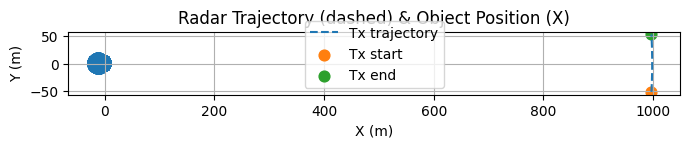

In [ ]:
sensor_xyz = sar.get_sensor_positions()
plot_radar_trajectory_and_object(
    object_xyz=c_objs,
    tx_traj=sensor_xyz, rx_traj=sensor_xyz,
    bistatic=False,          # True로 바꾸면 Tx/Rx 둘 다 점선 표시
)

In [14]:
# bp_image, xi, yi = sar.backprojection_image(signal=p_signal, coarse_pulse_stride=8)
bp_image, xi, yi, range_gate, auto_gate_used = sar.backprojection_image_fused(signal=p_signal, 
                                                  use_complex64=True,
                                                  auto_gate=False,
                                                  nx_coarse=96, ny_coarse=96, coarse_pulse_stride=4,
                                                  use_power_peak=False
                                                  
                                                  )


[BP fused chunk] pulses 0-9999 done
[BP fused chunk] pulses 10000-19999 done
[BP fused chunk] pulses 20000-28303 done


/tmp/ipykernel_16698/535393994.py:7: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(xi, yi, 20 * np.log10(np.abs(bp_image) / np.max(np.abs(bp_image))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)


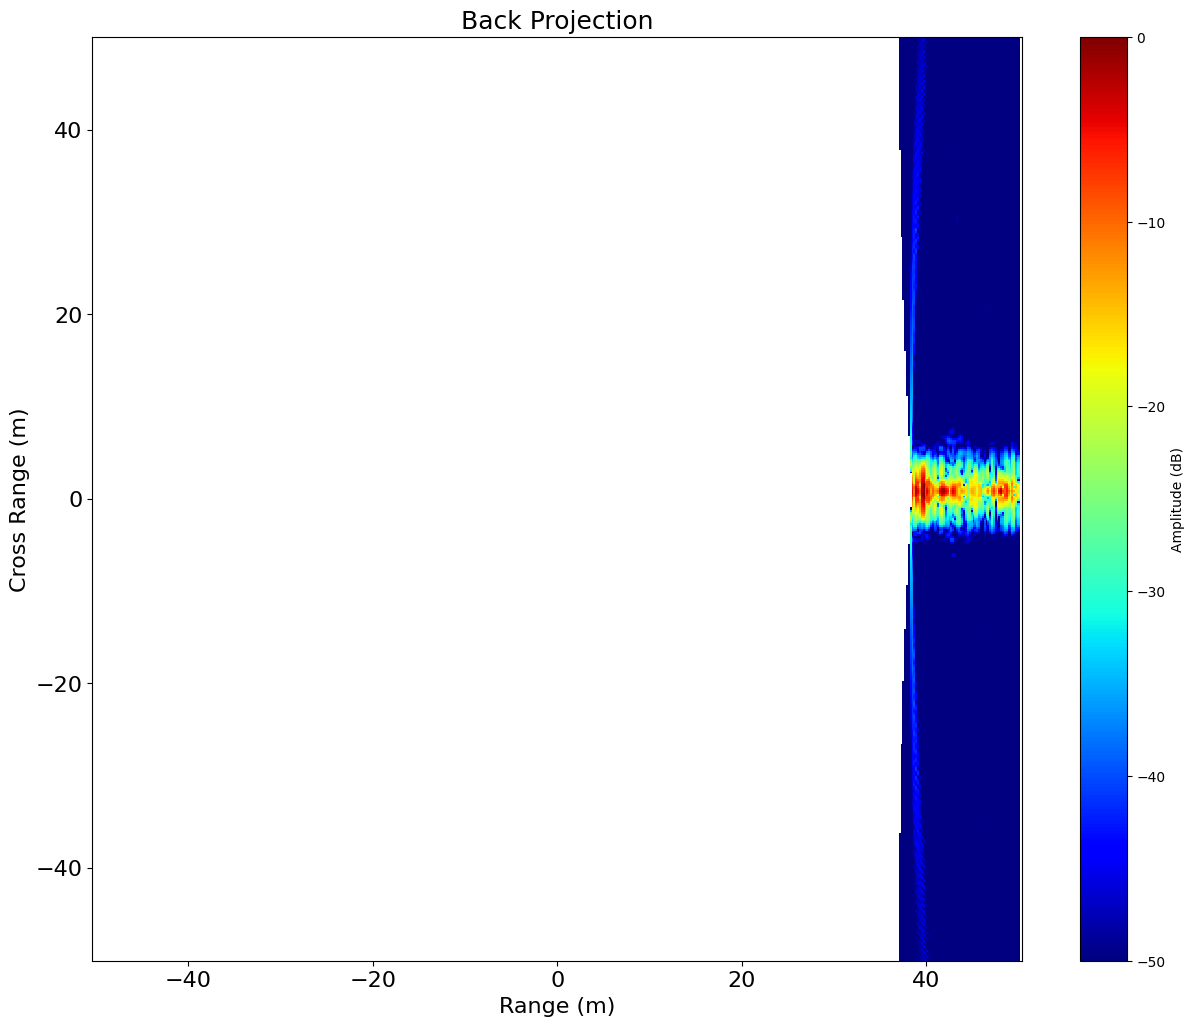

In [15]:

dynamic_range = 50
# Set the figure size
plt.rcParams["figure.figsize"] = (15, 12)

# Plot the backprojected image
plt.figure()
plt.pcolor(xi, yi, 20 * np.log10(np.abs(bp_image) / np.max(np.abs(bp_image))), cmap='jet', vmin=-abs(dynamic_range), vmax=0)

# Set the title and labels
plt.title('Back Projection', size=18)
plt.xlabel('Range (m)', size=16)
plt.ylabel('Cross Range (m)', size=16)



# Make the axes equal
plt.axis('equal')

# Set the tick label size
plt.tick_params(labelsize=16)

# Turn on the colorbar and set the label
cbar = plt.colorbar()
cbar.set_label('Amplitude (dB)')

# Show the figure
plt.show()

In [9]:
print(bp_image.shape)
print(bp_image[240:260, 240:260])

(500, 500)
[[-8.73328705e+01-1.93423279e+02j -4.00860687e+02-1.84557037e+02j
  -3.22725281e+02-2.38953293e+02j -4.56705933e+02-3.98994720e+02j
  -7.16728210e+02-2.69740715e+01j -4.43813934e+02+4.03724091e+02j
  -8.32416458e+01+2.77238037e+02j -5.64106560e+00+4.96028366e+01j
  -1.06843824e+01-7.05765772e+00j -3.26051861e-02+1.11897898e+00j
   2.56163031e-01+2.68807530e+00j -1.69079459e+00-1.41931653e-01j
  -4.40976024e-01-4.11504298e-01j -1.07799327e+00+2.00485277e+00j
  -7.35932812e-02+1.15916610e+00j  3.92451793e-01-4.47234750e-01j
  -3.35976154e-01-1.92639772e-02j -4.77631301e-01+6.01415634e-01j
  -5.39761037e-02+4.03449625e-01j -7.32393339e-02+6.92621350e-01j]
 [-1.05929619e+02-1.58148270e+02j -3.69026947e+02-1.09009460e+02j
  -2.99382904e+02-1.61577621e+02j -4.27553497e+02-2.82538116e+02j
  -6.08930420e+02+5.96736717e+01j -3.36554840e+02+3.87675323e+02j
  -5.59084587e+01+2.46895874e+02j -1.29573612e+01+5.97255554e+01j
  -8.95987415e+00+1.08558311e+01j  3.70084977e+00+4.78292418e+00